<a href="https://colab.research.google.com/github/quanvu0996/compet/blob/master/kalapa_4student_net2_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.metrics import AUC, Precision, Recall
import tensorflow.keras.backend as K
from tensorflow import feature_column as fc
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
print(pd.__version__)
print(tf.__version__)

1.0.5
2.3.0


## Load data

In [3]:
submision_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/simple_submission.csv'
train_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/train.csv'
test_path = '/content/drive/My Drive/Data/colabs_data/kalapa_4students/test.csv'

In [4]:
def load_data(train_path, test_path, label_col = 'label'):
    train_set = pd.read_csv(train_path)
    test_set = pd.read_csv(test_path)
    return train_set, test_set

train_set, test_set = load_data( train_path, test_path )
cols = train_set.columns

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (35,43) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (34,42) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [5]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53030 entries, 0 to 53029
Columns: 195 entries, id to Field_82
dtypes: float64(133), int64(3), object(59)
memory usage: 78.9+ MB


### Data trasforming

In [6]:
# train_set[cols_categorical].head()
# train_set.Field_61.unique()

In [7]:
# len(train_set.Field_45.unique())
# cols_id

In [8]:
# len(train_set.homeTownCity.unique())

In [9]:
# train_set.C_endDate.unique()
# train_set.homeTownCity.hist()
# print(cols_docs)

In [10]:
# train_set[cols_date].head()

In [11]:
# Nhãn
cols_label = ['label']
# Đặc trưng binary
cols_fts_binary = [i for i in train_set.select_dtypes(include=['float64','int64']).columns 
                   if len(set(train_set[i].fillna(0)) - {0,1} ) == 0 and i not in cols_label]
# định dang datte yyyy-mm-dd
cols_date = ['Field_1','Field_2','Field_5','Field_6','Field_7','Field_8','Field_9','Field_11'
             ,'Field_15','Field_25','Field_32','Field_33','Field_35','Field_40','Field_43','Field_44'
             ,'F_startDate','F_endDate','E_startDate','E_endDate','C_startDate','C_endDate','G_startDate','G_endDate'
             ,'A_startDate','A_endDate']
# định dạng date yyymmdd
cols_date2 = ['ngaySinh', 'Field_34']
# Đặc trưng dạng văn bản
cols_docs = ['Field_46','diaChi','Field_48','Field_49','currentLocationName','homeTownName','Field_56']
# Định danh bản ghi
cols_id = ['id','Field_45'] +[i for i in train_set.select_dtypes(include = ['object']).columns 
                              if len(train_set[i].unique()) >=350 and i not in cols_date + cols_date2+cols_docs]
# Đặc trưng dạng categorical
cols_categorical = [i for i in train_set.select_dtypes(include = ['object']).columns
                    if i not in cols_id + cols_label+cols_date2+cols_date+cols_docs]
# Đặc trưng số
cols_fts_num = [ i for i in test_set.select_dtypes(include=['float64','int64']).columns 
                if i not in cols_id + cols_label + cols_fts_binary + cols_date2+cols_date+cols_docs]

In [12]:
# cols_categorical
# cols_date2 = ['ngaySinh', 'Field_34']

In [13]:
# Đặc trưng số có dạng như categorical
cols_num_like_cat = [i for i in cols_fts_num if len(train_set[i].unique()) <= 15 ]
# Đặc trưng số đã kiểm chứng
cols_num = [i for i in cols_fts_num if i not in cols_num_like_cat]

cols_categorical = cols_categorical + cols_num_like_cat
cols_fts_num = [i for i in cols_fts_num if i not in cols_num_like_cat ]

In [14]:
# for i in cols_fts_num :
#   print(i, len(train_set[i].unique()))

Missing values

In [15]:
train_data = train_set
predict_data = test_set

# Categorical: Fill giá trị null như một giá trị khác
train_data[cols_categorical] = train_set[cols_categorical].astype('object').fillna('#NULL#').applymap(str)
predict_data[cols_categorical] = test_set[cols_categorical].astype('object').fillna('#NULL#').applymap(str)

In [16]:
# pd.to_datetime(train_data['Field_1']) - pd.to_datetime('2007-01-01 0000')
# (pd.to_datetime(pd.to_datetime(train_data['Field_1']).dt.date)-pd.to_datetime('2007-01-01') ).components
# (pd.to_datetime( train_data[col].apply(lambda x: str(x)[0:10]), format='%Y-%m-%d' ) 
#                         - pd.to_datetime('20170101', format='%Y%m%d') ).apply(lambda x: x.days)
# (pd.to_datetime( train_data[col].apply(lambda x: str(x)[0:10]), format='%Y%m%d' ) 
#                         - pd.to_datetime('20170101', format='%Y%m%d') ).apply(lambda x: x.days)


In [17]:
# Date: với dữ liệu ngày thì tạo ra các cột ngày tương ứng và cross colum => embedding để giảm chiều

def trans_date_fts(df, col, format = 'yyyy-mm-dd'):
  '''format là 'yyyy-mm-dd' hoặc 'yyyymmdd' '''

  year_name = 'year_of'+col 
  month_name = 'month_of' + col
  day_name = 'day_of' + col
  day_num_name = 'days_num_from_'+col
  if format == 'yyyy-mm-dd':
    df[year_name] = df[col].apply(lambda x: str(x[:4]) if len(str(x)) >8 else '#NULL#')
    df[month_name] = df[col].apply(lambda x: str(x[5:7]) if len(str(x)) >8 else '#NULL#')
    df[day_name] = df[col].apply(lambda x: str(x[8:10]) if len(str(x)) >8 else '#NULL#')
    df[day_num_name] = (pd.to_datetime( df[col].apply(lambda x: str(x)[0:10]), format='%Y-%m-%d' , errors= 'coerce') 
                        - pd.to_datetime('20170101', format='%Y%m%d') ).apply(lambda x: x.days)

  else:
    df[year_name] = df[col].apply(lambda x: str(x)[:4] if len(str(x)) >8 else '#NULL#')
    df[month_name] = df[col].apply(lambda x: str(x)[4:6] if len(str(x)) >8 else '#NULL#')
    df[day_name] = df[col].apply(lambda x: str(x)[6:8] if len(str(x)) >8 else '#NULL#')
    df[day_num_name] = (pd.to_datetime( df[col].apply(lambda x: str(x)[0:10]), format='%Y%m%d', errors= 'coerce' ) 
                        - pd.to_datetime('20170101', format='%Y%m%d') ).apply(lambda x: x.days)

  ft1 = fc.categorical_column_with_vocabulary_list(year_name, df[year_name].unique() )
  ft2 = fc.categorical_column_with_vocabulary_list(month_name, df[month_name].unique() )
  ft3 = fc.categorical_column_with_vocabulary_list(day_name, df[day_name].unique() )
  ft = fc.crossed_column([ft1, ft2, ft3], hash_bucket_size = 366)
  ft = fc.embedding_column(ft, dimension= 64)

  ft_1 = fc.numeric_column(day_num_name, dtype=tf.float32)

  return df, [ft, ft_1] , [year_name, month_name, day_name, day_num_name]

fts_col_date = []
date_derivated_fts = []
for col in cols_date:
  train_data, date_fts_list_add, date_fts_name = trans_date_fts(train_data, col,format = 'yyyy-mm-dd')
  fts_col_date += date_fts_list_add 
  date_derivated_fts += date_fts_name
for col in cols_date2:
  train_data, date_fts_list_add, date_fts_name = trans_date_fts(train_data, col,format = 'yyyymmdd')
  fts_col_date +=  date_fts_list_add 
  date_derivated_fts += date_fts_name

for col in cols_date:
  predict_data, date_fts_list_add, date_fts_name = trans_date_fts(predict_data, col,format = 'yyyy-mm-dd')
for col in cols_date2:
  predict_data, date_fts_list_add, date_fts_name = trans_date_fts(predict_data, col,format = 'yyyymmdd')


In [18]:
predict_data

,id,Field_1,Field_2,Field_3,Field_4,Field_5,Field_6,Field_7,Field_8,Field_9,Field_10,Field_11,Field_12,Field_13,Field_14,Field_15,Field_16,Field_17,Field_18,Field_19,Field_20,Field_21,Field_22,Field_23,Field_24,Field_25,Field_26,Field_27,Field_28,Field_29,Field_30,Field_31,Field_32,Field_33,Field_34,Field_35,ngaySinh,namSinh,gioiTinh,diaChi,...,year_ofE_startDate,month_ofE_startDate,day_ofE_startDate,days_num_from_E_startDate,year_ofE_endDate,month_ofE_endDate,day_ofE_endDate,days_num_from_E_endDate,year_ofC_startDate,month_ofC_startDate,day_ofC_startDate,days_num_from_C_startDate,year_ofC_endDate,month_ofC_endDate,day_ofC_endDate,days_num_from_C_endDate,year_ofG_startDate,month_ofG_startDate,day_ofG_startDate,days_num_from_G_startDate,year_ofG_endDate,month_ofG_endDate,day_ofG_endDate,days_num_from_G_endDate,year_ofA_startDate,month_ofA_startDate,day_ofA_startDate,days_num_from_A_startDate,year_ofA_endDate,month_ofA_endDate,day_ofA_endDate,days_num_from_A_endDate,year_ofngaySinh,month_ofngaySinh,day_ofngaySinh,days_num_from_ngaySinh,year_ofField_34,month_ofField_34,day_ofField_34,days_num_from_Field_34
0,53030,2019-10-14T01:37:41.959Z,2019-10-14T01:37:41.959Z,2.0,T1,8/27/2019,8/27/2019,9/24/2019,9/23/2020,8/27/2019,1.0,NaN,#NULL#,1.0,1.0,8/27/2019,1.0,1.0,NaN,0.000,1490000.0,4.5,1.0,43.0,1.0,8/27/2019,1.0,0.0,0.0,12.0,1.0,1.0,8/27/2019,2/24/2021,20190908,NaN,19950425.0,0.0,MALE,"11/1 Tổ 23 KP4, Phường Bửu Long, Thành phố Biê...",...,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,1995,04,25,-7922.0,#NULL#,#NULL#,#NULL#,980.0
1,53031,2019-09-10T09:20:40.066Z,2019-09-11T07:53:44Z,2.0,T1,9/10/2019,9/10/2019,9/14/2019,9/13/2020,9/10/2019,1.0,NaN,#NULL#,1.0,1.0,NaN,1.0,1.0,NaN,0.000,1043000.0,4.5,1.0,24.0,1.0,9/10/2019,1.0,0.0,0.0,12.0,1.0,1.0,9/11/2019,9/14/2022,20191003,NaN,19920930.0,0.0,MALE,"Xã Chu Minh, Huyện Ba Vì, Thành phố Hà Nội",...,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,1/14,20,0,NaN,1/14,20,0,NaN,1992,09,30,-8859.0,#NULL#,#NULL#,#NULL#,1005.0
2,53032,NaN,NaN,#NULL#,#NULL#,NaN,NaN,NaN,NaN,NaN,#NULL#,NaN,#NULL#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#NULL#,#NULL#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#NULL#,#NULL#,NaN,...,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN
3,53033,2019-10-21T03:29:30.074Z,2019-10-21T04:17:26Z,2.0,T1,10/21/2019,10/21/2019,11/15/2019,11/14/2020,10/21/2019,1.0,NaN,#NULL#,1.0,1.0,10/21/2019,1.0,1.0,NaN,0.000,1490000.0,4.5,1.0,0.0,1.0,10/21/2019,1.0,0.0,0.0,12.0,1.0,1.0,10/21/2019,11/15/2024,20191104,NaN,19961208.0,0.0,FEMALE,"Xã Hạ Bằng, Huyện Thạch Thất, Thành phố Hà Nội",...,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,1996,12,08,-7329.0,#NULL#,#NULL#,#NULL#,1037.0
4,53034,NaN,NaN,#NULL#,#NULL#,NaN,NaN,NaN,NaN,NaN,#NULL#,NaN,#NULL#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#NULL#,#NULL#,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,#NULL#,#NULL#,NaN,...,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,1/11,20,0,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN,#NULL#,#NULL#,#NULL#,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [19]:
X_train, X_test, y_train, y_test = train_test_split(train_data
                                                   ,train_data['label'].values
                                                   ,stratify = train_data['label'].values 
                                                   ,test_size = 0.2
                                                   )

In [20]:
# Numerical: các trường chưa xử lý+ numerical fill giá trị -1

# train_data[cols_fts_num] = train_set[cols_fts_num].fillna(-1)
# predict_data[cols_fts_num] = test_set[cols_fts_num].fillna(-1)
# X_train[cols_fts_num] = (X_train[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()
# X_test[cols_fts_num] = (X_test[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()
# predict_data[cols_fts_num] = (predict_data[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_train.mean())
predict_data = predict_data.fillna(X_train.mean())

Định nghĩa features

In [21]:
feature_columns = []
fts_cols = cols_fts_binary+cols_fts_num+cols_categorical + date_derivated_fts

# Với biến binary, load trực tiếp vào model
for col in cols_fts_binary:
  feature_columns.append(
      fc.numeric_column(col, dtype=tf.float32)
  )
# Với các biến numeric, sử dụng standard scaler + định nghĩa
# X_train[cols_fts_num] = (X_train[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()
# X_test[cols_fts_num] = (X_test[cols_fts_num] - X_train[cols_fts_num].mean() )/ X_train[cols_fts_num].std()

for col in cols_fts_num:
  mean = X_train[col].mean()
  std = X_train[col].std()
  feature_columns.append(
      fc.numeric_column(col,
                        dtype=tf.float32
                        #, normalizer_fn = lambda x: ( x - mean )/ std 
                        ))
# Với các biến categorical, embed với số chiều bằng 1/10 +1 số chiều gốc
def embed_trans(feature_name, vocab):
  ft = fc.categorical_column_with_vocabulary_list(feature_name, vocab)
  ft = fc.embedding_column( ft,dimension= int(len(vocab)/10) +5 )
  return ft
for col in cols_categorical:
  vocabulary = train_set[col].unique()
  feature_columns.append(
      embed_trans(col, vocabulary)
  )


# Xây dựng layer
all_fts_cols = feature_columns +fts_col_date
feature_layer = DenseFeatures(all_fts_cols)

In [22]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(X, y, shuffle=True, batch_size=32):
  ds = tf.data.Dataset.from_tensor_slices((X.to_dict(orient='list'), y))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(X))
  ds = ds.batch(batch_size)
  return ds

In [23]:
# X_train['days_num_from_A_endDate'].head()

In [24]:
# scaler_1 = StandardScaler()
# X_train_scaled = scaler_1.fit_transform(X_train)
# X_test_scaled = scaler_1.transform(X_test)
# X_predict_scaled = scaler_1.transform( test_set[cols_fts_num].fillna(0) )

In [25]:
nets_2 = Sequential(
    [
    feature_layer,
    BatchNormalization (),
    Dense(512, activation ='relu'),
    Dropout(0.25), 
    BatchNormalization (),
    Dense(256, activation ='relu'),
    Dropout(0.25), 
    Dense(128, activation ='relu'),
    Dropout(0.25), 
    BatchNormalization (),
    Dense(64, activation ='relu'),
    Dropout(0.1), 
    Dense(16, activation ='relu'),
    Dense(1, activation ='sigmoid')])
nets_2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc', AUC() ] ) #, Precision(), Recall()] )

In [26]:
batch_size = 5000 # A small batch sized is used for demonstration purposes
train_ds = df_to_dataset(X_train[fts_cols], y_train, batch_size=batch_size)
test_ds = df_to_dataset(X_test[fts_cols], y_test, shuffle=False, batch_size=batch_size)
predict_ds = df_to_dataset(predict_data[fts_cols], predict_data['id'], shuffle=False, batch_size=batch_size)

history = nets_2.fit( train_ds , epochs = 10
                    , validation_data = test_ds)
nets_2.summary()

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
9/9 [==============================] - ETA: 0s - loss: 0.6525 - acc: 0.6558 - auc: 0.5459WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Field_13': <tf.Tensor 'ExpandDims_10:0' shape=(None, 1) dtype=float32>, 'Field_14': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=float32>, 'Field_16': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=float32>, 'Field_17': <tf.Tensor 'ExpandDims_13:0' shape=(None, 1) dtype=float32>, 'Field_24': <tf.Tensor 'ExpandDims_19:0' shape=(None, 1) dtype=float32>, 'Field_26': <tf.Tensor 'ExpandDims_20:0' shape=(None, 1) dtype=float32>, 'Field_30': <tf.Tensor 'ExpandDims_25:0' shape=(None, 1) dtype=float32>, 'Field_31': <tf.Tensor 'ExpandDims_26:0' shape=(None, 1) dtype=float32>, 'Field_37': <tf.Tensor 'ExpandDims_28:0' shape=(None, 1) dtype=float32>, 'Fiel

Dự đoán và xuất file kế quả

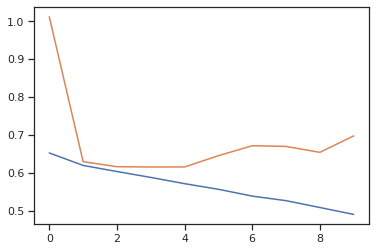

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [28]:
y_predict_pred= nets_2.predict(predict_ds )
y_predict_pred

Consider rewriting this model with the Functional API.


array([[0.5841982 ],
       [0.60082525],
       [0.5574541 ],
       ...,
       [0.48491138],
       [0.51876515],
       [0.56311625]], dtype=float32)

In [29]:
res_df = pd.DataFrame({'id': test_set.id, 'label': y_predict_pred.reshape(y_predict_pred.shape[0])})
res_df.to_csv('submission.csv', index=False)